<a href="https://colab.research.google.com/github/Relfick/conv-mnist/blob/main/Conv_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [ ]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [ ]:
X_train.shape

torch.Size([60000, 28, 28])

In [ ]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [ ]:
X_train.shape

torch.Size([60000, 1, 28, 28])

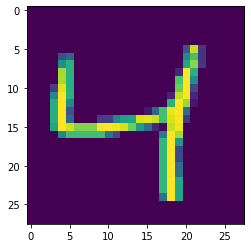

tensor(4)


In [ ]:
plt.imshow(X_train[2][0])
plt.show()
print(y_train[2])

# Model

In [ ]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        activation = 'ELU'

        # Слой 1
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, padding=2)
        self.act1 = eval(f'torch.nn.{activation}()')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Доп слой 1
        self.conv1ad = torch.nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, padding=2)
        self.act1ad = eval(f'torch.nn.{activation}()')
        self.pool1ad = torch.nn.AvgPool2d(kernel_size=2, stride=1)

        # Слой 2
        self.conv2 = torch.nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5, padding=0)
        self.act2 = eval(f'torch.nn.{activation}()')
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        # Доп слой 2
        self.conv2ad = torch.nn.Conv2d(in_channels=48, out_channels=96, kernel_size=5, padding=2)
        self.act2ad = eval(f'torch.nn.{activation}()')
        self.pool2ad = torch.nn.MaxPool2d(kernel_size=2, stride=1)

        # Линейные слои
        self.fc1 = torch.nn.Linear(3*3*96, 120)
        self.act3 = eval(f'torch.nn.{activation}()')
        
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = eval(f'torch.nn.{activation}()')
        
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # Доп слой 1
        x = self.conv1ad(x)
        x = self.act1ad(x)
        x = self.pool1ad(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # Доп слой 2
        x = self.conv2ad(x)
        x = self.act2ad(x)
        x = self.pool2ad(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

net = ConvNet()

In [ ]:
net = net.cuda()

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=net.parameters(), lr=1.0e-2, momentum=0.7)

# Learning

In [ ]:
test_accuracy_history = []
test_loss_history = []

X_test = X_test.cuda()
y_test = y_test.cuda()

batch_size = 100

for epoch in range(10000):
    shuffled_indexes = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = shuffled_indexes[start_index:start_index + batch_size]
        X_batch = X_train[batch_indexes].cuda()
        y_batch = y_train[batch_indexes].cuda()

        preds = net.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    test_preds = net.forward(X_test)

    #curr_loss = loss(test_preds, y_test).data.cpu()
    curr_accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(curr_accuracy)
    #test_loss_history.append(curr_loss)
    
    print('epoch =', epoch, '; accuracy =', round(curr_accuracy.item(), 3))



epoch = 0 ; accuracy = 0.984
epoch = 1 ; accuracy = 0.988
epoch = 2 ; accuracy = 0.99
epoch = 3 ; accuracy = 0.991
epoch = 4 ; accuracy = 0.991
epoch = 5 ; accuracy = 0.992


KeyboardInterrupt: ignored

In [ ]:
plt.plot(test_loss_history)